## 参考：https://blog.csdn.net/u013733326/article/details/79639509

* 初始化参数
* 计算损失函数和梯度
* 用优化算法（梯度下降 grident descent）

## 1 - Packages ##

- numpy ：是用Python进行科学计算的基本软件包。
- h5py：是与H5文件中存储的数据集进行交互的常用软件包。
- matplotlib：是一个著名的库，用于在Python中绘制图表。
- lr_utils ：在本文的资料包里，一个加载资料包里面的数据的简单功能的库。

In [31]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from lr_utils import load_dataset

## 2 - Overview of the Problem set


In [13]:
import numpy as np
import h5py
## 导入数据
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r") # 引入文件
#     for key in train_dataset.keys():
#         print(key)
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features（209 张 64x64）
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # labels(0不是猫  1猫)

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features（50张 64x64）
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) #  类别标签保存的是以bytes类型保存的两个字符串数据，数据为：[b’non-cat’ b’cat’]。
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# 数据加载到主程序中
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()


list_classes
train_set_x
train_set_y


(209, 64, 64, 3)
train_set_y=[[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]


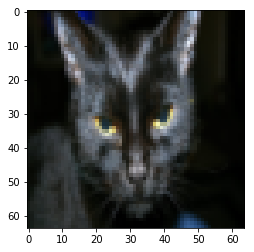

In [36]:
index = 25
plt.imshow(train_set_x_orig[index])
print(train_set_x_orig.shape)
print("train_set_y=" + str(train_set_y)) #你也可以看一下训练集里面的标签是什么样的。

In [37]:
#打印出当前的训练标签值
#使用np.squeeze的目的是压缩维度，【未压缩】train_set_y[:,index]的值为[1] , 【压缩后】np.squeeze(train_set_y[:,index])的值为1
#print("【使用np.squeeze：" + str(np.squeeze(train_set_y[:,index])) + "，不使用np.squeeze： " + str(train_set_y[:,index]) + "】")
#只有压缩后的值才能进行解码操作
print("y=" + str(train_set_y[:,index]) + 
      ", it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "' picture")
print("【使用np.squeeze：" + str(np.squeeze(train_set_y[:,index])) +
      "，不使用np.squeeze： " + str(train_set_y[:,index]) + "】")

y=[1], it's a cat' picture
【使用np.squeeze：1，不使用np.squeeze： [1]】


In [38]:
# train_set_x_orig 是一个维度为(m_train，num_px，num_px，3）的数组。
print(train_set_y.shape)
m_train = train_set_y.shape[1] # （1,209）训练集数量 1行，209列
m_test = test_set_y.shape[1] # 测试集图片数量
num_px = train_set_x_orig.shape[1] # 训练集和测试集的宽高度

print("训练集的数量：m_train = " + str(m_train))
print("测试集的数目：m_test = " + str(m_test))
print("每张图片的宽/高：num_px = " + str(num_px) )
print("训练集图片的维数：" + str(train_set_x_orig.shape))
print("训练集标签的维数：" + str(train_set_y.shape))
print("测试集图片的维数：" + str(test_set_x_orig.shape))
print("测试集的维数：" + str(test_set_y.shape))

(1, 209)
训练集的数量：m_train = 209
测试集的数目：m_test = 50
每张图片的宽/高：num_px = 64
训练集图片的维数：(209, 64, 64, 3)
训练集标签的维数：(1, 209)
测试集图片的维数：(50, 64, 64, 3)
测试集的维数：(1, 50)


为了方便，我们要把维度为（64，64，3）的numpy数组重新构造为（64 x 64 x 3，1）的数组，要乘以3的原因是每张图片是由64x64像素构成的，而每个像素点由（R，G，B）三原色构成的，所以要乘以3。在此之后，我们的训练和测试数据集是一个numpy数组，【每列代表一个平坦的图像】 ，应该有m_train和m_test列。

当你想将形状（a，b，c，d）的矩阵X平铺成形状（b * c * d，a）的矩阵X_flatten时，可以使用以下代码：

In [39]:
#X_flatten = X.reshape(X.shape [0]，-1).T ＃X.T是X的转置
#将训练集的维度降低并转置。
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
# 这一段意思是指把数组变为209行的矩阵（因为训练集里有209张图片），
# 但是我懒得算列有多少，于是我就用-1告诉程序你帮我算，最后程序算出来时12288列，
# 我再最后用一个T表示转置，这就变成了12288行，209列。测试集亦如此。


#将c测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

In [40]:
print ("训练集降维最后的维度： " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数 : " + str(test_set_y.shape))


训练集降维最后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)


为了表示彩色图像，必须为每个像素指定红色，绿色和蓝色通道（RGB），因此像素值实际上是从0到255范围内的三个数字的向量。机器学习中一个常见的预处理步骤是对数据集进行居中和标准化，这意味着可以减去每个示例中整个numpy数组的平均值，然后将每个示例除以整个numpy数组的标准偏差。但对于图片数据集，它更简单，更方便，几乎可以将数据集的每一行除以255（像素通道的最大值），因为在RGB中不存在比255大的数据，所以我们可以放心的除以255，让标准化的数据位于[0,1]之间，现在标准化我们的数据集：

In [41]:
train_set_x = train_set_x_flatten /255
test_set_x  = test_set_x_flatten / 255

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="https://zedwnutwhnkzdykkpsnyql.coursera-apps.org/notebooks/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/images/LogReg_kiank.png" style="width:650px;height:400px;">
现在总算是把我们加载的数据弄完了，我们现在开始构建神经网络。

以下是数学表达式，如果对数学公式不甚理解，请仔细看一下吴恩达的视频。

对于 $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

然后通过对所有训练样例求和来计算成本:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

建立神经网络的主要步骤是：

1. 定义模型结构（例如输入特征的数量）

2. 初始化模型的参数

3. 循环：

* 3.1 计算当前损失（正向传播）

* 3.2 计算当前梯度（反向传播）

* 3.3 更新参数（梯度下降）

### 4.1 - Helper functions
$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$     使用np.exp().

In [58]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [59]:
#测试sigmoid()
print("====================测试sigmoid====================")
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(10) = " + str(sigmoid(10)))

====================测试sigmoid====================
sigmoid(0) = 0.5
sigmoid(10) = 0.9999546021312976


### 4.2 - 初始化参数Initializing parameters

In [60]:
def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。
        
        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）
        
        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape = (dim,1))
    b = 0
    #使用断言来确保我要的数据是正确的
    assert(w.shape == (dim, 1)) #w的维度是(dim,1)
    assert(isinstance(b, float) or isinstance(b, int)) #b的类型是float或者是int
    
    return (w , b)


### 4.3 - Forward and Backward propagation
初始化参数的函数已经构建好了，现在就可以执行“前向”和“后向”传播步骤来学习参数。

我们现在要实现一个计算成本函数及其渐变的函数propagate（）。

In [77]:
def propagate(w, b, X, Y):
	"""
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
	m = X.shape[1] # m列
    #正向传播
	A = sigmoid(np.dot(w.T,X) + b) #计算激活值，请参考公式2。
	cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) #计算成本，请参考公式3和4。
    #反向传播
	dw = (1 / m) * np.dot(X, (A - Y).T) #请参考视频中的偏导公式。
	db = (1 / m) * np.sum(A - Y) #请参考视频中的偏导公式。
	#使用断言确保我的数据是正确的
	assert(dw.shape == w.shape)
	assert(db.dtype == float)
	cost = np.squeeze(cost)
	assert(cost.shape == ())
    
    #创建一个字典，把dw和db保存起来。
	grads = {
                "dw": dw,
                "db": db
             }
	return (grads , cost)


In [78]:
#测试一下propagate
print("====================测试propagate====================")
#初始化一些参数
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))


====================测试propagate====================
dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


### 4.4 - 梯度下降，更新参数Optimization
 $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [80]:
def optimize(w , b , X , Y , num_iterations , learning_rate , print_cost = False):
    """
    此函数通过运行梯度下降算法来优化w和b
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值
    
    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。
    
    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        #记录成本
        if i % 100 == 0:
            costs.append(cost)
        #打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 误差值： %f" % (i,cost))
        
    params  = {
                "w" : w,
                "b" : b }
    grads = {
            "dw": dw,
            "db": db } 
    return (params , grads , costs)


In [84]:
#测试optimize
print("====================测试optimize====================")
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
params , grads , costs = optimize(w , b , X , Y , num_iterations=100 , learning_rate = 0.009 , print_cost = False)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

====================测试optimize====================
w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828



1. 计算 $\hat{Y} = A = \sigma(w^T X + b)$

2. a的值变为0（如果激活值<= 0.5）或者为1（如果激活值> 0.5），

In [83]:
def predict(w , b , X ):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据
    
    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）
    
    """
    
    m  = X.shape[1] #图片的数量
    Y_prediction = np.zeros((1,m)) 
    w = w.reshape(X.shape[0],1)
    
    #计预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T , X) + b)
    for i in range(A.shape[1]):
        #将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
    #使用断言
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction


## 5 - Merge all functions into a model ##

就目前而言，我们基本上把所有的东西都做完了，现在我们要把这些函数统统整合到一个model()函数中，届时只需要调用一个model()就基本上完成所有的事了。

我们更改一下学习率和迭代次数，有可能会发现训练集的准确性可能会提高，但是测试集准确性会下降，这是由于过拟合造成的，但是我们并不需要担心，我们以后会使用更好的算法来解决这些问题的。

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [86]:
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):
    """
    通过调用之前实现的函数来构建逻辑回归模型
    
    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本
    
    返回：
        d  - 包含有关模型信息的字典。
    """
    w , b = initialize_with_zeros(X_train.shape[0])
    
    parameters , grads , costs = optimize(w , b , X_train , Y_train,num_iterations , learning_rate , print_cost)
    
    #从字典“参数”中检索参数w和b
    w , b = parameters["w"] , parameters["b"]
    
    #预测测试/训练集的例子
    Y_prediction_test = predict(w , b, X_test)
    Y_prediction_train = predict(w , b, X_train)
    
    #打印训练后的准确性
    print("训练集准确性："  , format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100) ,"%")
    print("测试集准确性："  , format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100) ,"%")
    
    d = {
            "costs" : costs,
            "Y_prediction_test" : Y_prediction_test,
            "Y_prediciton_train" : Y_prediction_train,
            "w" : w,
            "b" : b,
            "learning_rate" : learning_rate,
            "num_iterations" : num_iterations }
    return d

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
迭代的次数: 1000 ， 误差值： 0.214820
迭代的次数: 1100 ， 误差值： 0.203078
迭代的次数: 1200 ， 误差值： 0.192544
迭代的次数: 1300 ， 误差值： 0.183033
迭代的次数: 1400 ， 误差值： 0.174399
迭代的次数: 1500 ， 误差值： 0.166521
迭代的次数: 1600 ， 误差值： 0.159305
迭代的次数: 1700 ， 误差值： 0.152667
迭代的次数: 1800 ， 误差值： 0.146542
迭代的次数: 1900 ， 误差值： 0.140872
训练集准确性： 99.04306220095694 %
测试集准确性： 70.0 %


## 6 - Further analysis (optional/ungraded exercise) ##

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

我们可以比较一下我们模型的学习曲线和几种学习速率的选择。也可以尝试使用不同于我们初始化的learning_rates变量包含的三个值，并看一下会发生什么。

learning rate is: 0.01
训练集准确性： 99.52153110047847 %
测试集准确性： 68.0 %

-------------------------------------------------------

learning rate is: 0.001
训练集准确性： 88.99521531100478 %
测试集准确性： 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
训练集准确性： 68.42105263157895 %
测试集准确性： 36.0 %

-------------------------------------------------------



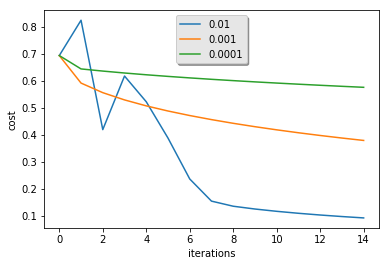

In [87]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()


## 7 - Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [92]:
from scipy import ndimage
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "my_image.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
image = image/255.
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

c:\users\hasee\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


FileNotFoundError: [Errno 2] No such file or directory: 'images/my_image.jpg'